## Importamos librerias de python y CSV

Se utilizará pandas para la manipulación de CSV, numpy para funciones matematicas, plotly para visualizar la información y math para pequeñas funciones


In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import math
import csv
from scipy.optimize import curve_fit

## Graficamos la carga de los pulsos contra la distancia a la cual se ubicó la fuente

Así se puede ver el cambio en la intensidad de la luz a traves de la distancia dentro de cada iteración

leyendo los datos ubicados en: C:/Users/Vicente/Desktop/Datos osciloscopio/prueba prototype 3/09 cm/09 cm.csv
leyendo los datos ubicados en: C:/Users/Vicente/Desktop/Datos osciloscopio/prueba prototype 3/10 cm/10 cm.csv
leyendo los datos ubicados en: C:/Users/Vicente/Desktop/Datos osciloscopio/prueba prototype 3/11 cm/11 cm.csv
leyendo los datos ubicados en: C:/Users/Vicente/Desktop/Datos osciloscopio/prueba prototype 3/12 cm/12 cm.csv
leyendo los datos ubicados en: C:/Users/Vicente/Desktop/Datos osciloscopio/prueba prototype 3/13 cm/13 cm.csv
leyendo los datos ubicados en: C:/Users/Vicente/Desktop/Datos osciloscopio/prueba prototype 3/14 cm/14 cm.csv
leyendo los datos ubicados en: C:/Users/Vicente/Desktop/Datos osciloscopio/prueba prototype 3/15 cm/15 cm.csv
leyendo los datos ubicados en: C:/Users/Vicente/Desktop/Datos osciloscopio/prueba prototype 3/16 cm/16 cm.csv
leyendo los datos ubicados en: C:/Users/Vicente/Desktop/Datos osciloscopio/prueba prototype 3/17 cm/17 cm.csv
leyendo lo

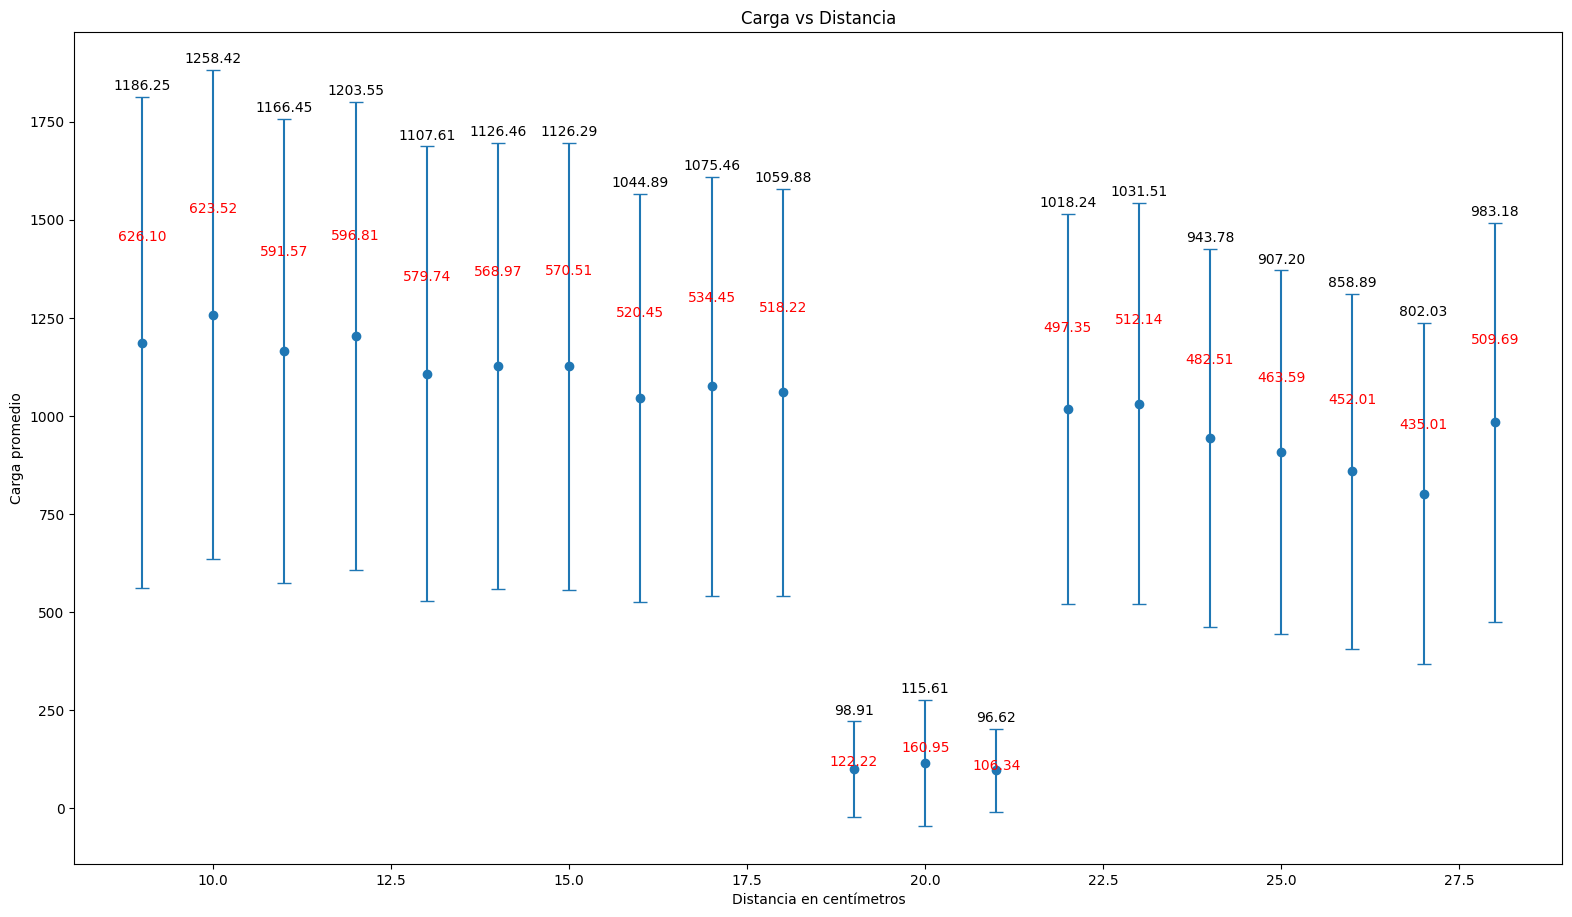

In [14]:
#integrales

#Parametros:
nombre_de_csv = 'proto 3.csv' #Recordar siempre poner .csv al final
Cantidad_de_pulsos = 6250
baseline = 1000
inicio_integral = 1500
salto_de_fila = 25 #Necesario si el archivo CSV incluye los headers
inicio = 9
fin = 28

#Listas vacias
lista_promedios = []
lista_std = []
largo_real = []

ruta_base = 'C:/Users/Vicente/Desktop/Datos osciloscopio/prueba prototype 3/'
largo_de_fibra = range(inicio,fin+1)

for x in largo_de_fibra:
    lista_integrales = []
    x = str(x).zfill(2)
    try:
            datos = f'{ruta_base}{x} cm/{x} cm.csv'
            print("leyendo los datos ubicados en:", datos)
            datos = pd.read_csv(datos, skiprows=salto_de_fila)


            for i in range(Cantidad_de_pulsos):
                Pulse = i
                datos_positivos = datos.iloc[:,2*Pulse+1].apply(lambda x : x*-1)
                #identificamos el baseline
                mean_baseline = datos_positivos[:baseline].mean()
                datos_corregidos = datos_positivos.apply(lambda x : x-mean_baseline)
                #Integramos con el metodo trapezoid de numpy
                integral = np.trapezoid(datos_corregidos[inicio_integral:],datos.iloc[inicio_integral:,2*Pulse])
                integral = integral/50 *10**12
                
                if integral >= 0:
                    lista_integrales.append(integral)

            largo_real.append(x)
    except FileNotFoundError:
         print("No se encontró",x,"cm")
         continue

    lista_promedios.append(np.mean(lista_integrales))
    lista_std.append(np.std(lista_integrales))


dpi = 100  # Definir los DPI
ancho_pulgadas = 1920 / dpi
alto_pulgadas = 1080 / dpi

# Crear la figura con el tamaño deseado
plt.figure(figsize=(ancho_pulgadas, alto_pulgadas), dpi=dpi)

# Graficar los puntos con barras de error
plt.errorbar(list(map(int, largo_real)), lista_promedios, yerr=lista_std, fmt='o', capsize=5)

# Agregar títulos y etiquetas a los ejes
plt.title("Carga vs Distancia")
plt.xlabel("Distancia en centímetros")
plt.ylabel("Carga promedio")

# Anotar cada punto con su valor en Y y el valor del error sobre las barras de error
for x, y, e in zip(list(map(int, largo_real)), lista_promedios, lista_std):
    # Anotar el valor en Y sobre la barra de error
    plt.annotate(f'{y:.2f}', (x, y + e), textcoords="offset points", xytext=(0,5), ha='center')
    # Anotar el valor del error sobre la barra de error
    plt.annotate(f'{e:.2f}', (x, y + e / 2), textcoords="offset points", xytext=(0,-15), ha='center', color='red')

# Mostrar el gráfico
plt.show()



with open(nombre_de_csv, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # Escribir los encabezados (opcional)
    writer.writerow(['Promedios de carga', 'Distancia', 'Desviacion estandar'])
    
    # Escribir los datos de ambas listas
    for l1, l2, l3 in zip(lista_promedios, largo_real, lista_std):
        writer.writerow([l1, l2, l3])

## Fit exponencial
Con el fin de encontrar la distancia de atenuación de la luz se realiza un fit con una exponencial negativa, de la forma f(x) = L0 * exp(-b * x). Así el valor b debería entregar la distancia que tiene que recorrer la luz para que su intensidad decaiga en un factor de 1/exp

C:\Users\Vicente\AppData\Local\Temp\ipykernel_15924\3048034012.py:3: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x)


la distancia de atenuación lambda es : 32.881397871381665 centimetros


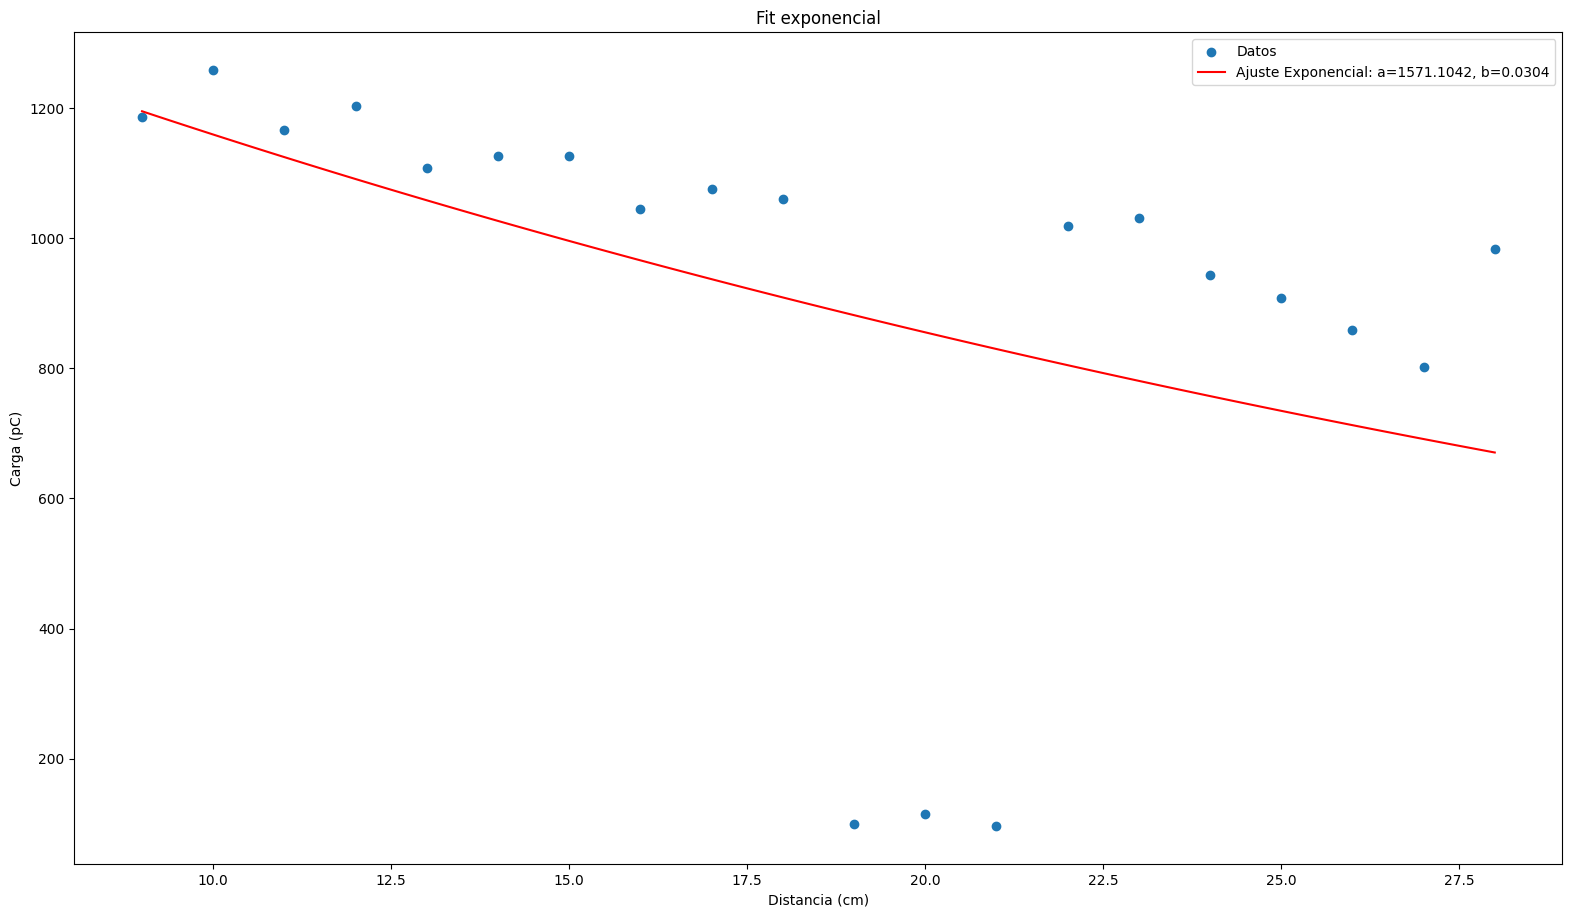

In [15]:
# Función exponencial negativa con parámetros de ajuste a y b
def exponencial_negativa(x, a, b):
    return a * np.exp(-b * x)


# Ajuste de la curva exponencial negativa
popt, pcov = curve_fit(exponencial_negativa, list(map(int, largo_real)), lista_promedios, p0=(1, 1))

b = popt[1]
print("la distancia de atenuación lambda es :", 1/b, "centimetros")

# Generar datos para la curva ajustada
x_fit = np.linspace(min(list(map(int, largo_real))), max(list(map(int, largo_real))), 100)
y_fit = exponencial_negativa(x_fit, *popt)

dpi = 100  # Definir los DPI
ancho_pulgadas = 1920 / dpi
alto_pulgadas = 1080 / dpi

# Crear la figura con el tamaño deseado
plt.figure(figsize=(ancho_pulgadas, alto_pulgadas), dpi=dpi)

# Graficar los datos y el ajuste
plt.scatter(list(map(int, largo_real)), lista_promedios, label='Datos')
plt.plot(x_fit, y_fit, color='red', label=f'Ajuste Exponencial: a={popt[0]:.4f}, b={popt[1]:.4f}')

# Agregar títulos y etiquetas a los ejes
plt.title("Fit exponencial")
plt.xlabel("Distancia (cm)")
plt.ylabel("Carga (pC)")
plt.legend()

# Mostrar el gráfico
plt.show()


## Visualizador de gráficas

Los datos de las gráficas anteriores son guardados en un archivo formato CSV, de esta forma se pueden volver a visualizar sin tener que obtener las integrales de todos los pulsos.

En primer lugar se importan solo las librerias necesarias, luego se realizan las mismas graficas anteriores con la información guardada en algun CSV que haya sido compuesto por la parte anterior del codigo.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

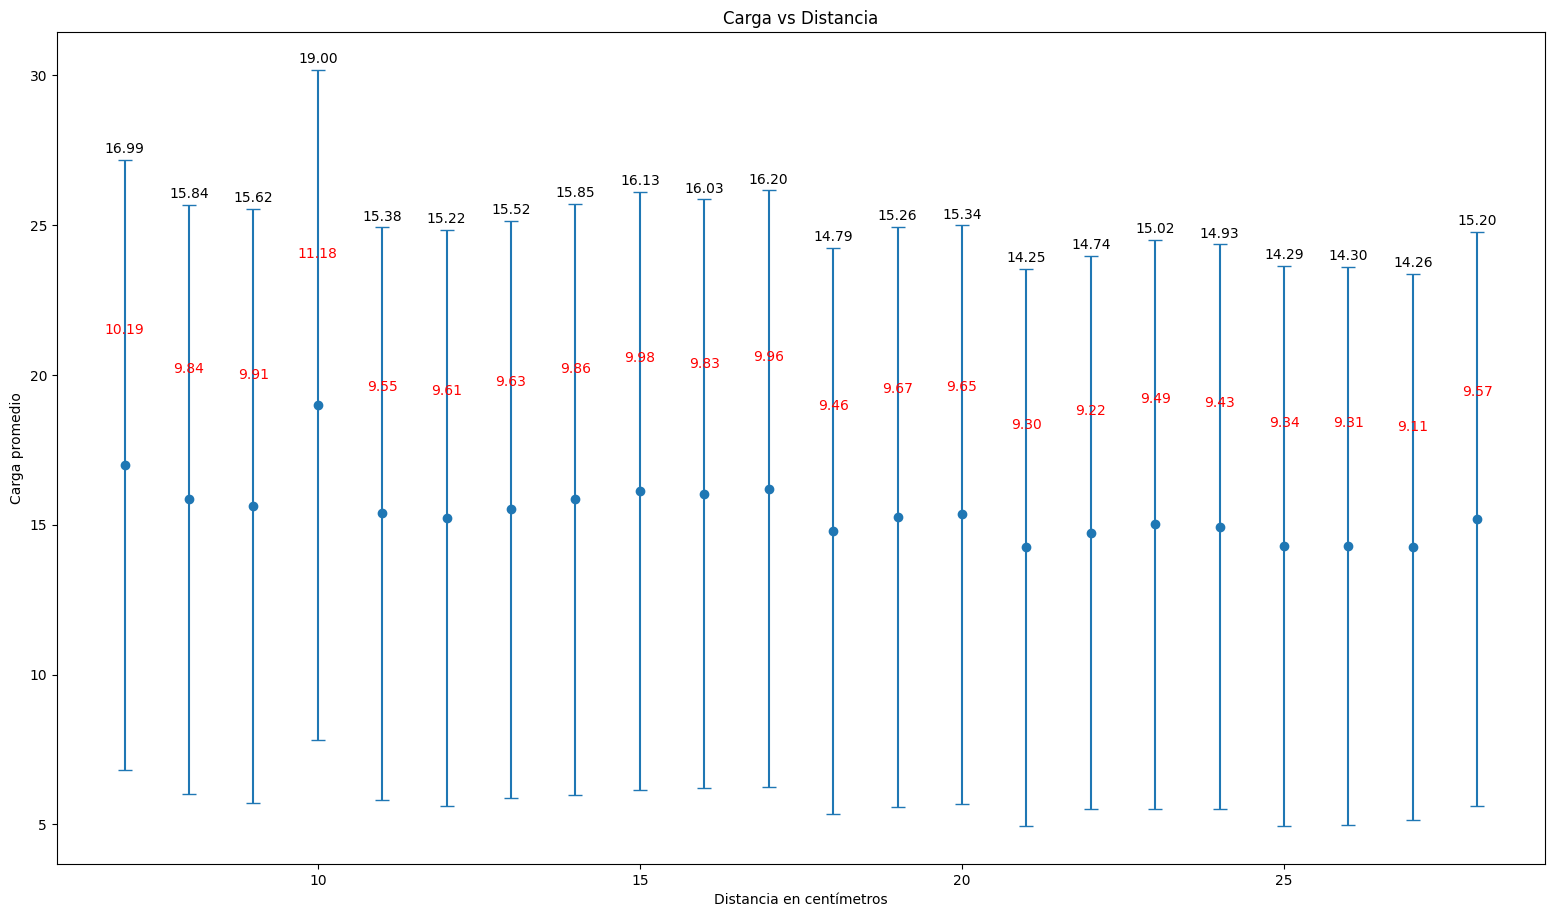

In [25]:
ruta_base = 'C:/Users/Vicente/Desktop/Vicente/archivo.csv'
datos = pd.read_csv(ruta_base)


columna_x = datos['Distancia']
columna_y = datos['Promedios de carga']
errores = datos['Desviacion estandar']

dpi = 100  # Definir los DPI
ancho_pulgadas = 1920 / dpi
alto_pulgadas = 1080 / dpi

# Crear la figura con el tamaño deseado
plt.figure(figsize=(ancho_pulgadas, alto_pulgadas), dpi=dpi)

# Graficar los puntos con barras de error
plt.errorbar(columna_x, columna_y, yerr=errores, fmt='o', capsize=5)

# Agregar títulos y etiquetas a los ejes
plt.title("Carga vs Distancia")
plt.xlabel("Distancia en centímetros")
plt.ylabel("Carga promedio")

# Anotar cada punto con su valor en Y y el valor del error sobre las barras de error
for x, y, e in zip(columna_x, columna_y, errores):
    # Anotar el valor en Y sobre la barra de error
    plt.annotate(f'{y:.2f}', (x, y + e), textcoords="offset points", xytext=(0,5), ha='center')
    # Anotar el valor del error sobre la barra de error
    plt.annotate(f'{e:.2f}', (x, y + e / 2), textcoords="offset points", xytext=(0,-15), ha='center', color='red')

# Mostrar el gráfico
plt.show()

c:\Users\Vicente\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


la distancia de atenuación lambda es : 140.1990634079528 centimetros


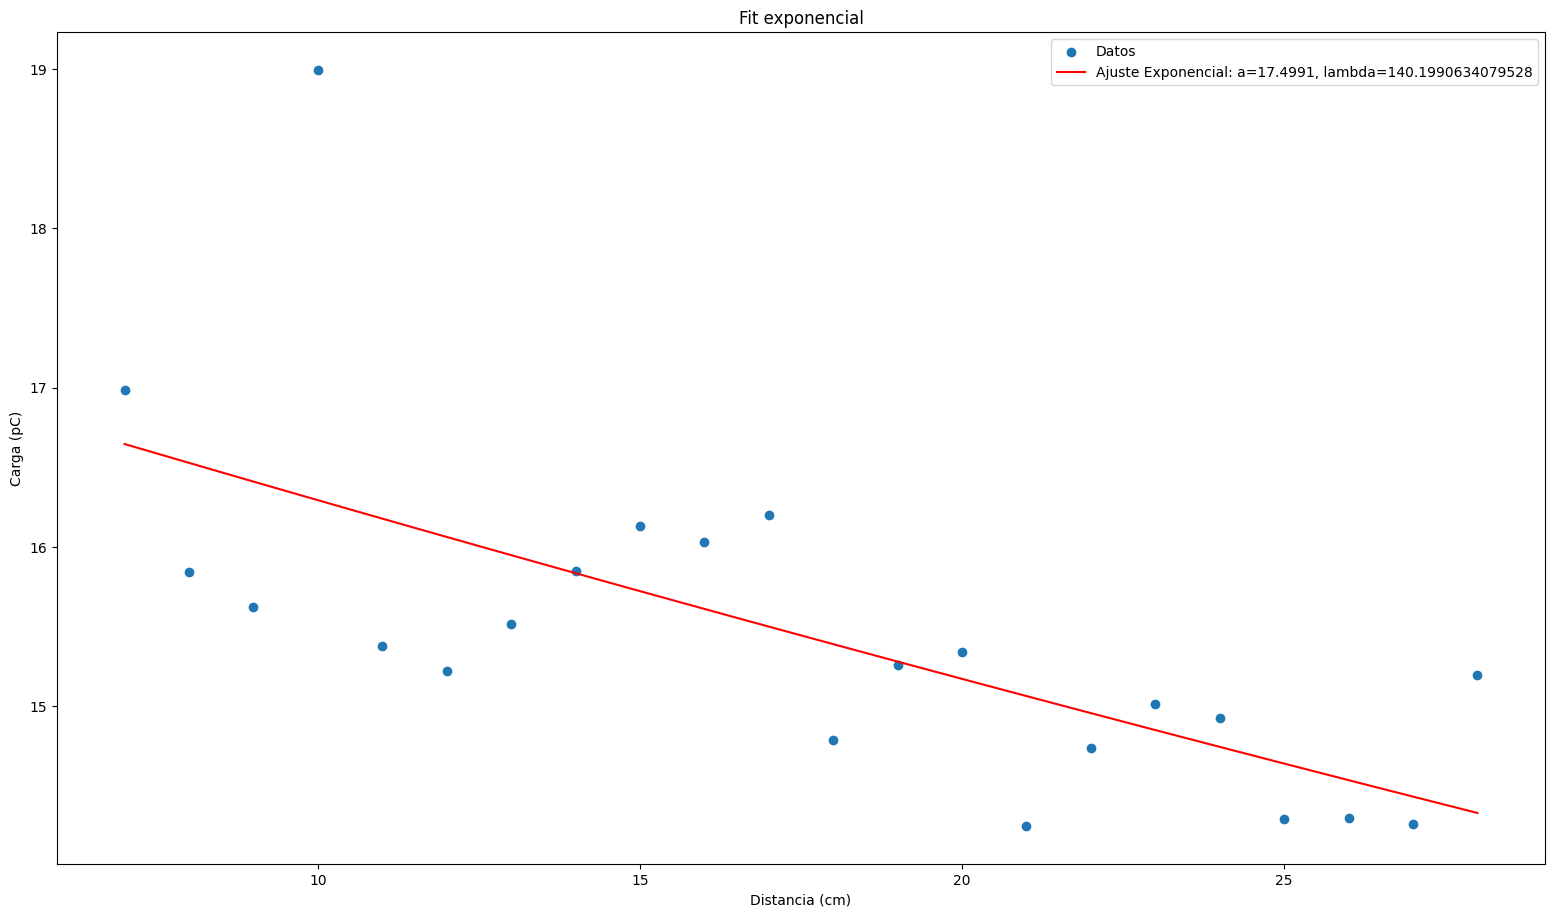

In [27]:

# Función exponencial negativa con parámetros de ajuste a y b
def exponencial_negativa(x, a, b):
    return a * np.exp(-b * x)


# Ajuste de la curva exponencial negativa
popt, pcov = curve_fit(exponencial_negativa, columna_x, columna_y, p0=(1, 1))

b = popt[1]
print("la distancia de atenuación lambda es :", 1/b, "centimetros")

# Generar datos para la curva ajustada
x_fit = np.linspace(min(columna_x), max(columna_x), 100)
y_fit = exponencial_negativa(x_fit, *popt)

dpi = 100  # Definir los DPI
ancho_pulgadas = 1920 / dpi
alto_pulgadas = 1080 / dpi

# Crear la figura con el tamaño deseado
plt.figure(figsize=(ancho_pulgadas, alto_pulgadas), dpi=dpi)

# Graficar los datos y el ajuste
plt.scatter(columna_x, columna_y, label='Datos')
plt.plot(x_fit, y_fit, color='red', label=f'Ajuste Exponencial: a={popt[0]:.4f}, lambda={1/b}')

# Agregar títulos y etiquetas a los ejes
plt.title("Fit exponencial")
plt.xlabel("Distancia (cm)")
plt.ylabel("Carga (pC)")
plt.legend()

# Mostrar el gráfico
plt.show()
